In [1]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
ma_list = [3,5,10,20,30]
stock_symbol = 'AAPL'

df = yf.Ticker(stock_symbol).history(period='5y')
df = df.iloc[:,:-2]

df['Premarket_Change'] = df.Open - df.Close.shift(1)

# Get the Moving Average data
for col in ['Close','Volume']:
    for ma in ma_list:
        df[f'{col}_{ma}MA'] = df[col].rolling(ma).mean().shift(1)

df.dropna(inplace=True)

# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_df = scaler.fit_transform(df.values)

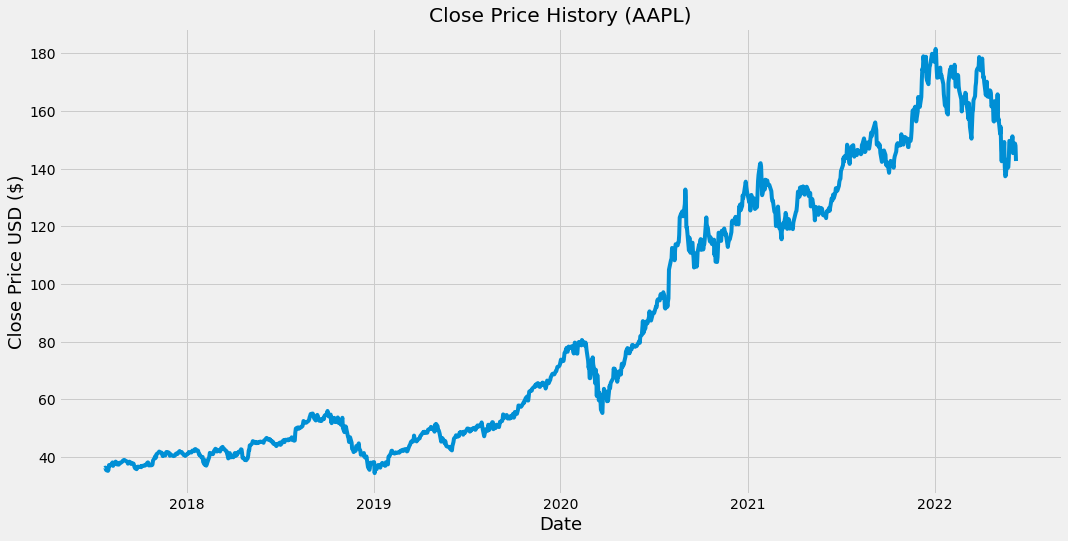

In [3]:
# Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title(f'Close Price History ({stock_symbol})')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [4]:
# Construct train and test data set
num_timestamp = 60
num_step = 10
train_length = math.ceil(len(df) * 0.8)

# Creating training data set
train = scaled_df[:train_length, : ]
x_train = []
y_train = []

for i in range(num_timestamp, train_length-num_step):
    x_train.append(train[i-num_timestamp:i, : ])
    y_train.append(train[i:i+num_step, 3 ])

x_train, y_train = np.array(x_train), np.array(y_train)

# Creating testing data set
test = scaled_df[train_length-num_timestamp: , : ]
test_unscaled = df.iloc[train_length-num_timestamp: , : ].values
x_test = []
y_test = []

for i in range(num_timestamp, len(test)-num_step+1):
    x_test.append(test[i-num_timestamp:i, : ])
    y_test.append(test_unscaled[i:i+num_step, 3 ])

x_test, y_test = np.array(x_test), np.array(y_test)

# LSTM expect the input to be 3D in the form of (# of samples, timestamp, # of features)
print(f'Shape of x_train: {x_train.shape}')
print(f'Shape of x_test: {x_test.shape}')
print(f'Shape of y_train: {y_train.shape}')
print(f'Shape of y_test: {y_test.shape}')

Shape of x_train: (914, 60, 16)
Shape of x_test: (236, 60, 16)
Shape of y_train: (914, 10)
Shape of y_test: (236, 10)


In [5]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(num_timestamp,x_train.shape[2])))
model.add(LSTM(100, return_sequences=False))
model.add(Dense(40))
model.add(Dense(num_step))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(x_train, y_train, batch_size=1, epochs=25)
# model.save(f'model/LSTMStockModel({stock_symbol}).h5')

Epoch 1/25
914/914 [==============================] - 9s 10ms/step - loss: 0.0029
Epoch 2/25
914/914 [==============================] - 9s 9ms/step - loss: 0.0015
Epoch 3/25
914/914 [==============================] - 9s 10ms/step - loss: 0.0012
Epoch 4/25
914/914 [==============================] - 8s 9ms/step - loss: 0.0010
Epoch 5/25
914/914 [==============================] - 8s 9ms/step - loss: 0.0012
Epoch 6/25
914/914 [==============================] - 8s 9ms/step - loss: 9.9596e-04
Epoch 7/25
914/914 [==============================] - 8s 9ms/step - loss: 9.4822e-04
Epoch 8/25
914/914 [==============================] - 8s 9ms/step - loss: 8.6785e-04
Epoch 9/25
914/914 [==============================] - 8s 9ms/step - loss: 7.6928e-04
Epoch 10/25
914/914 [==============================] - 9s 9ms/step - loss: 7.9315e-04
Epoch 11/25
914/914 [==============================] - 8s 9ms/step - loss: 8.1342e-04
Epoch 12/25
914/914 [==============================] - 8s 9ms/step - loss: 7.4644

In [6]:
# Get the model predicted price values
predictions = model.predict(x_test)
for i in range(predictions.shape[0]):
    temp_matrix = np.zeros((num_step, 16))
    temp_matrix[:,3] = np.reshape(predictions[i], (num_step, ))
    predictions[i] = scaler.inverse_transform(temp_matrix)[:, 3]

In [7]:
total = 0
n = 0
for i in range(len(y_test)):
    for j in range(len(y_test[i])):
        n += 1
        total += (predictions[i][j] - y_test[i][j])**2

rmse = np.sqrt(total/n)
rmse

22.155741147621516

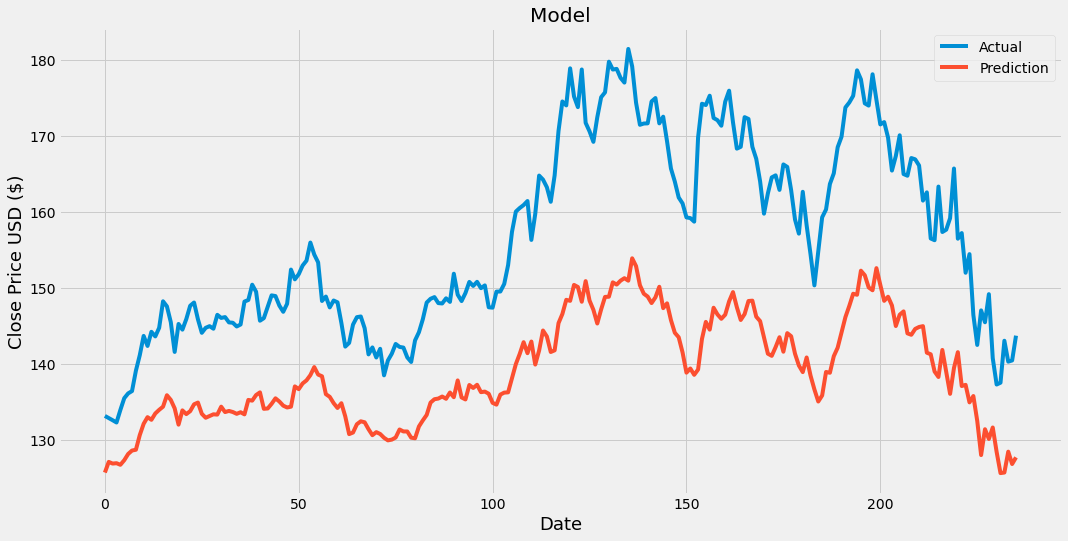

In [27]:
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(y_test[:,0], label='Actual')
plt.plot(predictions[:,0], label='Prediction')
plt.legend()
plt.show()

<ipython-input-8-481b68ed92cc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions[-1-i]


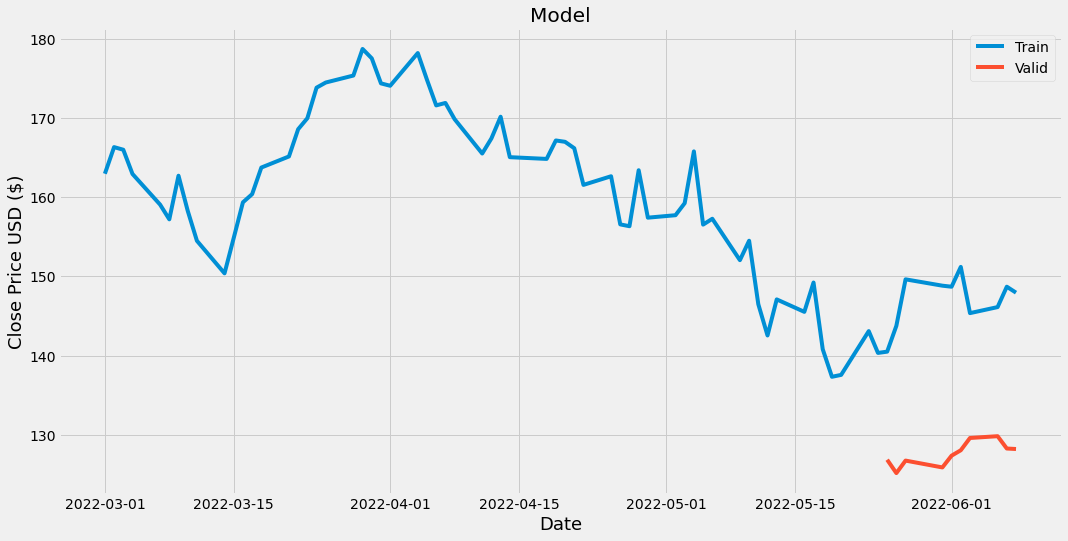

In [8]:
i = 1
valid = df[-num_step-i:-i]
valid['Predictions'] = predictions[-1-i]
# Visualize
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(df[-(num_step+num_timestamp)-i:-i]['Close'])
plt.plot(valid[['Predictions']])
plt.legend(['Actual', 'Predictions'], loc='upper right')
plt.show()